# EDA :

In [101]:
import pandas as pd
import math
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

In [103]:
df_raw = pd.read_csv('dpi_dataset.csv')

In [104]:
df_raw.columns

Index(['msisdn', 'event_date', 'cgi', 'rat', 'profile_name', 'quota_name',
       'protocol', 'accessed_category', 'accessed_app', 'total_volume_bcp',
       'hits_tether', 'rxmit_packets_in', 'rxmit_packets_out', 'packets_in',
       'packets_out', 'bucket_usage', 'flag'],
      dtype='object')

# Data Handling :

In [105]:
df_raw['total_packets'] = df_raw['packets_in']+df_raw['packets_out']
df_raw['total_rxmit'] = df_raw['rxmit_packets_in']+df_raw['rxmit_packets_out']

In [106]:
to_flag_cols = ['bucket_usage', 'total_volume_bcp', 'total_rxmit', 'total_packets']
flag_cols = ['bucket_usage_labels', 'total_volume_bcp_labels', 'total_rxmit_labels', 'total_packets_labels']
for col in to_flag_cols:
    df_raw[col + '_labels'] = (df_raw[col] > df_raw[col].median())
    df_raw[col + '_labels'] = df_raw[col + '_labels'].astype(int) #convert from boolean to integer
df_raw
for col in flag_cols:
    print(col + ' 0 count:', df_raw[col].count()-df_raw[col].sum())
    print(col + ' 1 count:', df_raw[col].sum())

bucket_usage_labels 0 count: 38198
bucket_usage_labels 1 count: 38198
total_volume_bcp_labels 0 count: 38198
total_volume_bcp_labels 1 count: 38198
total_rxmit_labels 0 count: 38199
total_rxmit_labels 1 count: 38197
total_packets_labels 0 count: 38199
total_packets_labels 1 count: 38197


In [107]:
df_raw['event_date']  = pd.to_datetime(df_raw.event_date.astype(str), format='%Y-%m-%d')

df_join = df_raw.copy()
for col in to_flag_cols:
    df_tes = df_join.copy()
    df_tes = df_tes[['msisdn', 'event_date',col +'_labels']]
    df_tes = df_tes.groupby(['msisdn', 'event_date']).max().reset_index()
    
    dummy_date =  df_tes[['event_date']].min() - timedelta(days=7)
    df_date = df_tes[['event_date']].drop_duplicates()
    df_date.iloc[-1]= dummy_date
    df_date.index = df_date.index+1
    dates = df_date.set_index('event_date').resample('D').asfreq().index
    
    msisdn = df_tes['msisdn'].unique()
    
    idx = pd.MultiIndex.from_product((dates, msisdn), names=['event_date', 'msisdn'])
    
    df_tes = df_tes.set_index(['event_date', 'msisdn']).reindex(idx).reset_index().sort_values(by=['event_date', 'msisdn'], ascending=True).reset_index(level=0, drop=True).fillna(0)
    df_tes[col +'_count'] = df_tes.groupby(['msisdn'])[col +'_labels'].rolling(7).sum().reset_index(level=0, drop=True)
    df_tes = df_tes.drop([col +'_labels'],1)
    
    df_join = pd.merge(df_join, df_tes,  how='left', left_on=['msisdn','event_date'], right_on = ['msisdn','event_date'])


In [108]:
df_raw = df_join.drop(['accessed_app','quota_name','profile_name','rat','protocol'], axis=1)

In [109]:
for col in to_flag_cols:
    df_raw[col + '_labels'] = (df_raw[col] > df_raw[col].median())
    df_raw[col + '_labels'] = df_raw[col + '_labels'].astype(int) #convert from boolean to integer
df_raw.head(3)

,msisdn,event_date,cgi,accessed_category,total_volume_bcp,hits_tether,rxmit_packets_in,rxmit_packets_out,packets_in,packets_out,...,total_packets,total_rxmit,bucket_usage_labels,total_volume_bcp_labels,total_rxmit_labels,total_packets_labels,bucket_usage_count,total_volume_bcp_count,total_rxmit_count,total_packets_count
0,6281210065203,2020-12-12,510100333058031,SocialNet,3765457177,0,9488,311,2608160,799119,...,3407279,9799,0,1,1,1,0.0,1.0,1.0,1.0
1,6281210077714,2020-12-01,510100148743021,Web,3633776001,0,430,942,2348290,1665496,...,4013786,1372,0,1,1,1,1.0,1.0,1.0,1.0
2,6281210077714,2020-12-01,510100148743022,Web,7242484799,0,3148,3555,4649069,3960297,...,8609366,6703,1,1,1,1,1.0,1.0,1.0,1.0


In [110]:
df_raw['bucket_usage_count'] =df_raw.groupby(['msisdn', 'accessed_category', 'event_date'])['bucket_usage_labels'].transform('sum')
df_raw['total_volume_bcp_count'] =df_raw.groupby(['msisdn', 'accessed_category', 'event_date'])['total_volume_bcp_labels'].transform('sum')
df_raw['total_rxmit_count'] =df_raw.groupby(['msisdn', 'accessed_category', 'event_date'])['total_rxmit_labels'].transform('sum')
df_raw['total_packets_count'] =df_raw.groupby(['msisdn', 'accessed_category', 'event_date'])['total_packets_labels'].transform('sum')

# One Hot Encoding for Categorical Features :

In [111]:
one_hot = pd.get_dummies(df_raw['accessed_category'])

df_raw = df_raw.drop('accessed_category',axis = 1)
df_raw = df_raw.join(one_hot)

# Learning

In [91]:
import pickle

In [92]:
pkl_filename = "Picke_RFC_v2.pkl"

In [94]:
# Load the Model back from file
with open(pkl_filename, 'rb') as file:  
    Pickled_rfc = pickle.load(file)

Pickled_rfc

RandomForestClassifier()

In [95]:
Pickled_rfc.predict(df_raw)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
score = pickle_model.score(df_learn)

In [22]:
df_learn.to_csv('Pred_202101.csv', index=False)

In [27]:
df_learn = pd.read_csv('learn_RFC.csv')

In [28]:
df_learn.columns

Index(['msisdn', 'event_date', 'cgi', 'total_volume_bcp', 'hits_tether',
       'rxmit_packets_in', 'rxmit_packets_out', 'packets_in', 'packets_out',
       'bucket_usage', 'flag', 'total_packets', 'total_rxmit',
       'bucket_usage_labels', 'total_volume_bcp_labels', 'total_rxmit_labels',
       'total_packets_labels', 'bucket_usage_count', 'total_volume_bcp_count',
       'total_rxmit_count', 'total_packets_count', 'Ads', 'AppleServices',
       'ApplicationStore', 'Attack', 'Automotive', 'Backup', 'CDN',
       'CloudServices', 'CloudStorage', 'Communications', 'DeviceServices',
       'Education', 'Enterprise', 'FileSharing', 'Finance', 'Games',
       'GoogleServices', 'Images', 'Lifestyle', 'Mail', 'Media', 'Music',
       'Net', 'News', 'P2P', 'Productivity', 'Proxy', 'Remote', 'SocialNet',
       'Sports', 'Technology', 'Telco', 'Update', 'VPN', 'Video', 'Web',
       'WebApps', 'eCommerce', 'non-established', 'unclassified'],
      dtype='object')

In [29]:
(df_learn.corr()*100)['flag']

msisdn                       9.540235
cgi                         13.788490
total_volume_bcp            20.123776
hits_tether                -16.804374
rxmit_packets_in            10.285771
rxmit_packets_out            4.998026
packets_in                  19.068462
packets_out                 19.333511
bucket_usage                20.693671
flag                       100.000000
total_packets               20.150788
total_rxmit                 10.437471
bucket_usage_labels         15.571835
total_volume_bcp_labels     15.823270
total_rxmit_labels          28.928183
total_packets_labels        18.293619
bucket_usage_count          29.778225
total_volume_bcp_count      28.836047
total_rxmit_count           29.555793
total_packets_count         29.675505
Ads                         -0.703058
AppleServices               -0.579776
ApplicationStore             4.179459
Attack                      54.527318
Automotive                  -0.236685
Backup                      -2.551095
CDN         

In [ ]:
df_learn = df_learn.drop(['rxmit_packets_out'], axis=1)

In [ ]:
df_learn = df_learn.dropna()
df_learn

In [ ]:
X = df_learn

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print(len(X_train), len(X_test))

61116 15280


# RF Classifier :

In [34]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [35]:
y_pred = rfc.predict(X_test)

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[10511   163]
 [  832  3774]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     10674
           1       0.96      0.82      0.88      4606

    accuracy                           0.93     15280
   macro avg       0.94      0.90      0.92     15280
weighted avg       0.94      0.93      0.93     15280



# Feature Importance :

In [ ]:
for i,j in enumerate(rfc.feature_importances_):
    print(df_learn.columns[i],'\t\t', j*100)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
cross_val = KFold(n_splits=3, random_state=42)
scores = cross_val_score(rfc, X_test, y_test, cv=cross_val, scoring='roc_auc')
print("Mean AUC Score - Decision Tree: ", scores.mean())

# SHAP :

In [47]:
import shap

In [ ]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_test)

# Pickling :

In [38]:
import pickle

In [39]:
Pkl_Filename = "Picke_RFC_v1.pkl"
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(rfc, file)

In [41]:
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Pickled_rfc = pickle.load(file)

Pickled_rfc

RandomForestClassifier()

In [43]:
# Use the Reloaded Model to 
# Calculate the accuracy score and predict target values

# Calculate the Score 
score = Pickled_rfc.score(X_test, y_test)  
# Print the Score
print("Test score: {0:.2f} %".format(100 * score))  

# Predict the Labels using the reloaded Model
Ypredict = Pickled_rfc.predict(X_test)  

Ypredict

Test score: 90.37 %


array([0, 1, 0, ..., 0, 0, 0])

# PyCaret :

In [37]:
from pycaret.classification import *

In [38]:
df_tes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76396 entries, 0 to 76395
Data columns (total 61 columns):
msisdn                     76396 non-null int64
event_date                 76396 non-null datetime64[ns]
cgi                        76396 non-null int64
total_volume_bcp           76396 non-null int64
hits_tether                76396 non-null int64
rxmit_packets_in           76396 non-null int64
rxmit_packets_out          76396 non-null int64
packets_in                 76396 non-null int64
packets_out                76396 non-null int64
bucket_usage               76396 non-null int64
flag                       76396 non-null int64
total_packets              76396 non-null int64
total_rxmit                76396 non-null int64
bucket_usage_labels        76396 non-null int64
total_volume_bcp_labels    76396 non-null int64
total_rxmit_labels         76396 non-null int64
total_packets_labels       76396 non-null int64
bucket_usage_count         76396 non-null int64
total_volume_bcp_c

In [39]:
df_tes.columns

Index(['msisdn', 'event_date', 'cgi', 'total_volume_bcp', 'hits_tether',
       'rxmit_packets_in', 'rxmit_packets_out', 'packets_in', 'packets_out',
       'bucket_usage', 'flag', 'total_packets', 'total_rxmit',
       'bucket_usage_labels', 'total_volume_bcp_labels', 'total_rxmit_labels',
       'total_packets_labels', 'bucket_usage_count', 'total_volume_bcp_count',
       'total_rxmit_count', 'total_packets_count', 'Ads', 'AppleServices',
       'ApplicationStore', 'Attack', 'Automotive', 'Backup', 'CDN',
       'CloudServices', 'CloudStorage', 'Communications', 'DeviceServices',
       'Education', 'Enterprise', 'FileSharing', 'Finance', 'Games',
       'GoogleServices', 'Images', 'Lifestyle', 'Mail', 'Media', 'Music',
       'Net', 'News', 'P2P', 'Productivity', 'Proxy', 'Remote', 'SocialNet',
       'Sports', 'Technology', 'Telco', 'Update', 'VPN', 'Video', 'Web',
       'WebApps', 'eCommerce', 'non-established', 'unclassified'],
      dtype='object')

In [40]:
clf1 = setup(data = df_tes, 
             target = 'flag',
             numeric_imputation = 'median',
             categorical_features = ['bucket_usage_labels',
'total_volume_bcp_labels',
'total_rxmit_labels',
'total_packets_labels',
'Attack',
'Communications',
'GoogleServices',
'Music',
'Proxy',
'SocialNet',
'Video',
'Web',], 
             ignore_features = ['msisdn', 'event_date', 'cgi'],
             silent = True)

,Description,Value
0,session_id,5948
1,Target,flag
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(76396, 61)"
5,Missing Values,False
6,Numeric Features,13
7,Categorical Features,44
8,Ordinal Features,False
9,High Cardinality Features,False


In [41]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9327,0.9624,0.8167,0.9519,0.879,0.8328,0.8375,0.652
et,Extra Trees Classifier,0.9314,0.9605,0.8177,0.9459,0.8771,0.8299,0.8342,0.505
catboost,CatBoost Classifier,0.9283,0.9631,0.8032,0.9497,0.8703,0.8213,0.8268,9.083
xgboost,Extreme Gradient Boosting,0.9272,0.9622,0.8024,0.9465,0.8685,0.8186,0.824,47.84
lightgbm,Light Gradient Boosting Machine,0.9264,0.9621,0.795,0.9511,0.866,0.8159,0.8221,0.686
gbc,Gradient Boosting Classifier,0.9203,0.9552,0.7705,0.9546,0.8527,0.7989,0.8075,1.639
ada,Ada Boost Classifier,0.9144,0.9468,0.7593,0.9439,0.8416,0.7839,0.7926,0.422
dt,Decision Tree Classifier,0.898,0.883,0.8455,0.8197,0.8324,0.7591,0.7594,0.467
lda,Linear Discriminant Analysis,0.8528,0.8947,0.5867,0.8825,0.7047,0.6119,0.6346,0.122
qda,Quadratic Discriminant Analysis,0.808,0.7922,0.6144,0.8834,0.6589,0.5521,0.5915,0.064


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5948, verbose=0,
                       warm_start=False)

In [42]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9362,0.9656,0.8221,0.9592,0.8854,0.8416,0.8464
1,0.9329,0.9603,0.8171,0.952,0.8794,0.8333,0.8379
2,0.934,0.9654,0.8227,0.9503,0.8819,0.8364,0.8406
3,0.9295,0.9625,0.8159,0.941,0.874,0.8254,0.8294
4,0.9346,0.961,0.8226,0.9523,0.8827,0.8377,0.842
5,0.9237,0.9536,0.7839,0.9529,0.8602,0.8084,0.8157
6,0.9344,0.965,0.8176,0.9569,0.8818,0.8367,0.8417
7,0.9329,0.9613,0.8195,0.9493,0.8797,0.8334,0.8378
8,0.9359,0.9643,0.8214,0.9585,0.8846,0.8406,0.8454
9,0.9332,0.9646,0.8239,0.9462,0.8808,0.8347,0.8386


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


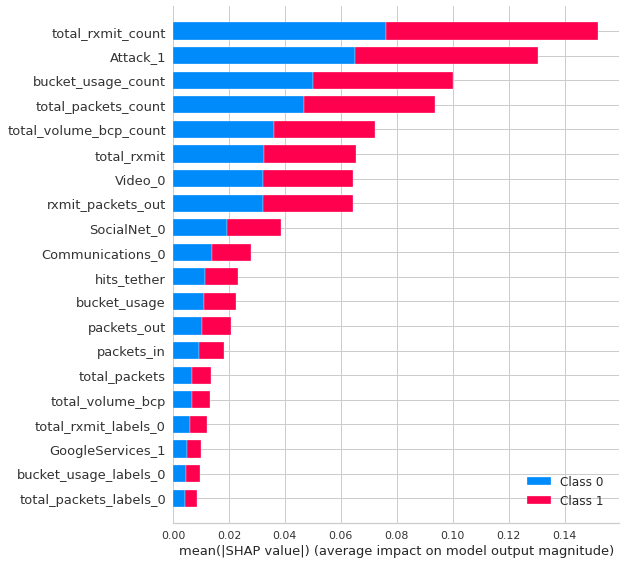

In [45]:
interpret_model(rf)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


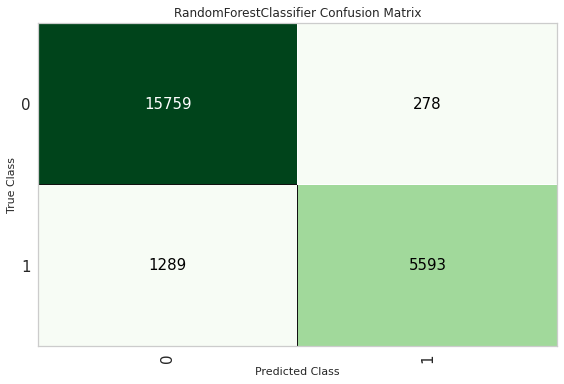

In [43]:
plot_model(estimator = rf, plot = 'confusion_matrix')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


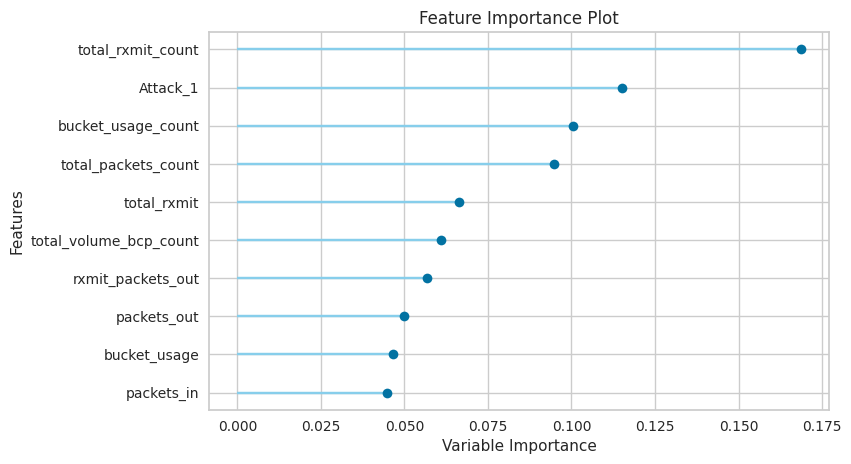

In [44]:
plot_model(estimator = rf, plot = 'feature')

In [ ]:
predict_model(rf, data=df_tes)

In [ ]:
predictions = predict_model(rf, data = df_tes)
sample['flag'] = predictions['pred_flag']
sample.to_csv('predicted_fraud_flag.csv',index=False)
sample.head()